In [14]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from os.path import join
from sklearn.metrics import f1_score, classification_report
import json

In [15]:
datadir = "../data/experiments/"
#TODO zmień tutaj ściezke do plików
dataset_names = ["doccano1", "hate_speech", "unhealthy"]
curr_dataset = "doccano1" # TODO wybierz nazwe datasetu z powyzszej listy
# curr_dataset = "hate_speech"

C_file = f"C_{curr_dataset}.csv"
increment_file = f"increment_{curr_dataset}.csv"
single_file = f"single_{curr_dataset}.csv"
thresholds_file = f"thresholds_{curr_dataset}.csv"

In [16]:
LABEL_COLUMNS = {
#     TODO zmienić nazwy polskie na angielskie
    "doccano1": ["Pozytywne", "Negatywne", "Radość", "Zachwyt","Inspiruje","Spokój","Zaskoczenie","Współczucie","Strach","Smutek","Wstręt","Złość","Ironiczny","Żenujący","Wulgarny","Polityczny","Interesujący","Zrozumiały","Potrzebuję więcej informacji, aby ocenić ten tekst","Obraża mnie","Może kogoś atakować / obrażać / lekceważyć","Mnie bawi/śmieszy?","Może kogoś bawić?"],
    "hate_speech": ["sentiment","respect","insult","humiliate","status","dehumanize","violence","genocide","attack_defend","hatespeech"],
    "unhealthy": ["antagonize","condescending","dismissive","generalisation_unfair","hostile","sarcastic"],
}

In [17]:
def read_data(file):
    df = pd.read_csv(join(datadir, file))
    print(df.columns)
    if "text" in df.columns:
        return df.drop(columns=["text"])
    return df

In [31]:
def convert_column_to_matrix(df, column):
    mapped = map(lambda x: np.fromstring(str(x).replace("]","").replace("[",""), sep=", "), df[column].tolist())
    matrix = np.stack(list(mapped), axis=0)
    return matrix

In [42]:
df_AB = read_data(C_file)
df_increment = read_data(increment_file)
df_single = read_data(single_file)
df_thresholds = read_data(thresholds_file)

Index(['labels', 'predictions', 'text', 'fold', 'label'], dtype='object')
Index(['labels', 'predictions', 'text', 'fold', 'threshold'], dtype='object')


In [7]:
def compute_F1(true, preds):
    macro_per_class, score_per_class_1, score_per_class_0 = [], [], []
    for i in range(true.shape[1]):
        score = f1_score(true[:,i], preds[:,i], average="macro")
        score_1 = f1_score(true[:,i], preds[:,i], pos_label=1)
        score_0 = f1_score(true[:,i], preds[:,i], pos_label=0, zero_division=0)
        score_per_class_1.append(score_1)
        score_per_class_0.append(score_0)
        macro_per_class.append(score)
        
    macro_per_class = np.stack(macro_per_class, axis=0)
    macro = macro_per_class.mean()
    score_per_class_1 = np.stack(score_per_class_1, axis=0)
    score_1 = score_per_class_1.mean()
    score_per_class_0 = np.stack(score_per_class_0, axis=0)
    score_0 = score_per_class_0.mean()
    
    score_for_1 = f1_score(true.flatten(), preds.flatten(), pos_label=1)
    score_for_0 = f1_score(true.flatten(), preds.flatten(), pos_label=0, zero_division=0)

    """
    TODO nazwy chciałem zeby były krótkie i troche odzwierciedlały co robią - kolejność jest zachowana według dokumentu .docx
    to gdzie są listy to są dane, które sa per_dim/per_class, a te obok to są uśrednione listy, wyjątkiem są f1_for_1 i f1_for_0 bo to są wymiary po flatten
    
    """
    return {"macro_per_dim": list(macro_per_class), "macro": macro,
            "f1_for_1":score_for_1, "f1_for_0":score_for_0, "mean_for_1_0": (score_for_1 + score_for_0)/2,
            "1_per_dim":list(score_per_class_1), "mean_for_1":score_1,
            "0_per_dim":list(score_per_class_0), "mean_for_0":score_0}


In [8]:
def get_array(data, key):
    array = np.array([x[key] for _, x in data.items()])
    return array, array.mean(axis=0), array.std(axis=0)

In [68]:
def plot_barplot(fig, means, stds, name, x=None, show=True):
    if x is None:
        x = LABEL_COLUMNS[curr_dataset] + ["all"]
    fig.add_trace(
        go.Bar(
            name=name,
            x=x,
            y=means,
            error_y=dict(
                type="data",
                array=stds,
                visible=True,
            ),
            showlegend=show
        )
    )

def AB_experiment(df, per_class_label = "macro_per_dim", mean_label = "macro"):
    folds_num = df["fold"].max() + 1
    
    f1_AA, f1_BA = {}, {}
    
    for fold in range(folds_num):
        curr_data = df[df["fold"]==fold]
        A_label = convert_column_to_matrix(curr_data, "A_label")
        B_label = convert_column_to_matrix(curr_data, "B_label")
        C_label = convert_column_to_matrix(curr_data, "predicted")
        
        dims = A_label.shape[1]
        
        f1_AA[fold] = compute_F1(A_label, B_label)
        f1_BA[fold] = compute_F1(A_label, C_label)
    
    with open(join(datadir, f"f1_AA_{curr_dataset}.json"), "w") as f:
        json.dump(f1_AA, f)
        
    with open(join(datadir, f"f1_BA_{curr_dataset}.json"), "w") as f:
        json.dump(f1_BA, f)
    
    aa, means_aa, stds_aa = get_array(f1_AA, per_class_label)
    scalar_aa, mean_aa, std_aa = get_array(f1_AA, mean_label)
    
    ba, means_ba, stds_ba = get_array(f1_BA, per_class_label)
    scalar_ba, mean_ba, std_ba = get_array(f1_BA, mean_label)
    
    fig = go.Figure()
    
    plot_barplot(fig, list(means_aa) + [mean_aa], list(stds_aa) + [std_aa], "A")
    plot_barplot(fig, list(means_ba) + [mean_ba], list(stds_ba) + [std_ba], "B")
    
    
    
    fig.update_layout(
        title=dict(
            text="F1 per dimension in A-B experiment",
        ),
        width=1500,
        height=500,
    )
    
    fig.show()
    
    
    diff_means = (ba-aa).mean(axis=0)
    diff_stds = (ba-aa).std(axis=0)
    diff_mean = (scalar_ba-scalar_aa).mean()
    diff_std = (scalar_ba-scalar_aa).std()
    
    fig = go.Figure()
    
    plot_barplot(fig, list(diff_means) + [diff_mean], list(diff_stds) + [diff_std], "difference")
    
    
    fig.update_layout(
        title=dict(
            text="Difference F1 per dimension in A-B experiment",
        ),
        width=1500,
        height=500,
    )
    
    fig.show()
    
    
    

In [11]:
AB_experiment(df_AB)

In [40]:
def increment_experiment(df, per_class_label = "macro_per_dim", mean_label = "macro"):
    folds_num = df["test_fold"].max() + 1
    
    f1_data = {} 
    
    for fold in range(folds_num):
        curr_data = df[df["test_fold"]==fold]
        original = convert_column_to_matrix(curr_data, "original")
        
        for i in range(1,9):
            curr_matrix = convert_column_to_matrix(curr_data, str(i))
            if f"train_{i}" not in f1_data:
                f1_data[f"train_{i}"] = {}
            f1_data[f"train_{i}"][fold] = compute_F1(original, curr_matrix)

    
    with open(join(datadir, f"f1_increment_{curr_dataset}.json"), "w") as f:
        json.dump(f1_data, f)

    plot_data = {}
    for i in range(1,9):
        _, means, stds = get_array(f1_data[f"train_{i}"], per_class_label)
        _, mean, std = get_array(f1_data[f"train_{i}"], mean_label)
        plot_data[i] = (list(means) + [mean], list(stds) + [std])
        
    fig = go.Figure()
    
    for i, (means, std) in plot_data.items():
        plot_barplot(fig, means, std, f"{i} folds")

    
    fig.update_layout(
        title=dict(
            text="F1 per dimension in increment experiment",
        ),
        width=3000,
        height=500,
    )
    
    fig.show()
        

In [43]:
increment_experiment(df_increment)

In [69]:
def single_training_experiment(df, per_class_label = "macro_per_dim", mean_label = "macro"):
    folds_num = df["fold"].max() + 1
    
    f1_data = {} 
    labels = df["label"].unique()
    for fold in range(folds_num):
        curr_data = df[df["fold"]==fold]
        for label in labels:
            curr_data_thresh = curr_data[curr_data["label"] == label]
            curr_matrix = convert_column_to_matrix(curr_data_thresh, "predictions")
            original = convert_column_to_matrix(curr_data_thresh, "labels")
            if label not in f1_data:
                f1_data[label] = {}
            f1_data[label][fold] = compute_F1(original, curr_matrix)

    
    with open(join(datadir, f"f1_single_training_{curr_dataset}.json"), "w") as f:
        json.dump(f1_data, f)

    plot_data = {}
    for label in labels:
        _, means, stds = get_array(f1_data[label], per_class_label)
        _, mean, std = get_array(f1_data[label], mean_label)
        plot_data[label] = (list(means) + [mean], list(stds) + [std])
        
    fig = go.Figure()
    
    for i, (means, std) in plot_data.items():
        plot_barplot(fig, means, std, i, x=[i], show=False)
    
    fig.update_layout(
        title=dict(
            text="F1 per dimension in single dimension training experiment",
        ),
        width=1500,
        height=500,
    )
    
    fig.show()

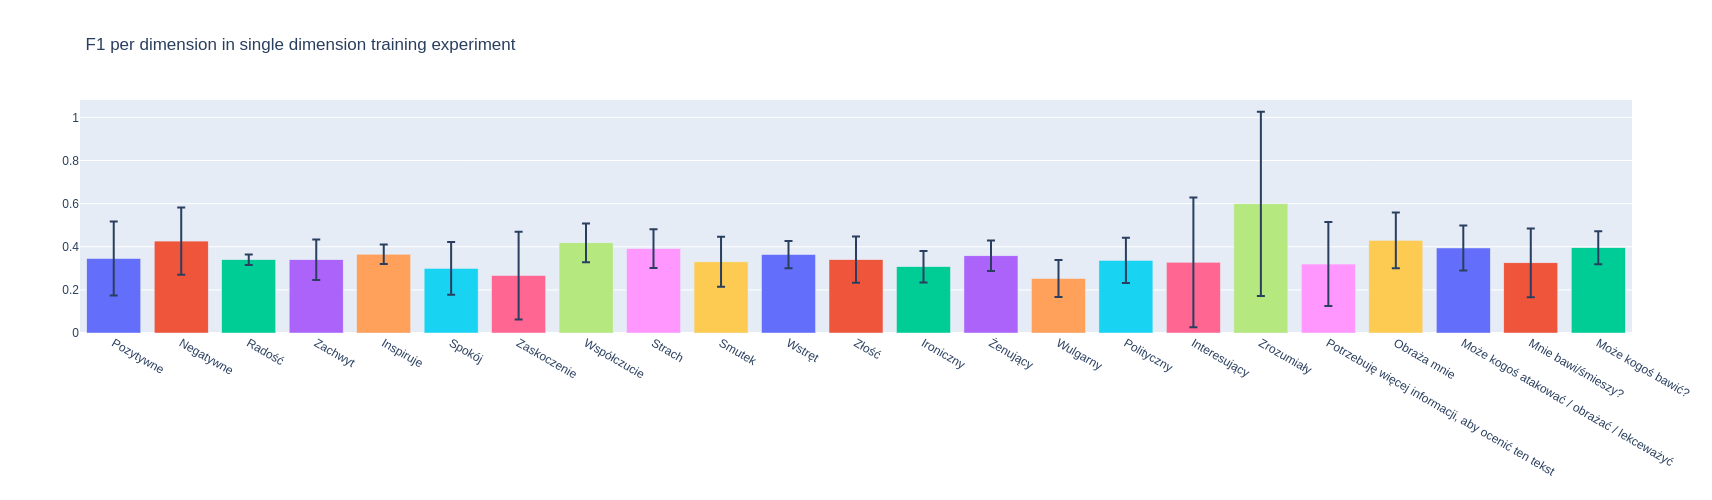

In [70]:
single_training_experiment(df_single)

In [52]:
def threshold_experiment(df, per_class_label = "macro_per_dim", mean_label = "macro"):
    folds_num = df["fold"].max() + 1
    
    f1_data = {} 
    thresholds = df["threshold"].unique()
    for fold in range(folds_num):
        curr_data = df[df["fold"]==fold]
        for th in thresholds:
            curr_data_thresh = curr_data[curr_data["threshold"] == th]
            curr_matrix = convert_column_to_matrix(curr_data_thresh,"predictions")
            original = convert_column_to_matrix(curr_data_thresh, "labels")
            if f"th_{th}" not in f1_data:
                f1_data[f"th_{th}"] = {}
            f1_data[f"th_{th}"][fold] = compute_F1(original, curr_matrix)

    
    with open(join(datadir, f"f1_threshold_{curr_dataset}.json"), "w") as f:
        json.dump(f1_data, f)

    plot_data = {}
    for th in thresholds:
        _, means, stds = get_array(f1_data[f"th_{th}"], per_class_label)
        _, mean, std = get_array(f1_data[f"th_{th}"], mean_label)
        plot_data[th] = (list(means) + [mean], list(stds) + [std])
        
    fig = go.Figure()
    
    for i, (means, std) in plot_data.items():
        plot_barplot(fig, means, std, i)

    
    fig.update_layout(
        title=dict(
            text="F1 per dimension in threshold experiment",
        ),
        width=1500,
        height=500,
    )
    
    fig.show()
        

In [54]:
threshold_experiment(df_thresholds)